## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch.univariate import ZeroMean, GARCH
import pmdarima as pm
import yfinance as yf
from arch import arch_model
from pmdarima.model_selection import train_test_split
from Utils import homepath, compute_returns, compute_conditional_volatility

import warnings
warnings.filterwarnings("ignore")

## Data

In [3]:
sp500_prices = pd.read_csv(homepath + "data/sp500_timeseries.txt", sep='\t', parse_dates=['Date'], index_col='Date')
sp500_index = pd.read_csv(homepath + "data/indices.csv", parse_dates=["Date"], index_col="Date")["sp500"]
rf_series = pd.read_csv(homepath + "data/interest_rates.csv", parse_dates=["Date"], index_col="Date")["3M T-Bill Rate"]
rf_series.resample("W").last().drop("2020-01-05")

rets = compute_returns(sp500_prices)

## GARCH-in-mean (GARCH-M)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5432.497183940557
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2223.823249497697
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4607.386676722278
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1585.9055796273426
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1542.4786939859168
Iteration:      6,   Func. Count:     35,   Neg. LLF: 1539.8753565433126
Iteration:      7,   Func. Count:     39,   Neg. LLF: 1539.861192972389
Iteration:      8,   Func. Count:     43,   Neg. LLF: 1539.8610171473838
Iteration:      9,   Func. Count:     47,   Neg. LLF: 1539.8610109988645
Iteration:     10,   Func. Count:     50,   Neg. LLF: 1539.8610109987158
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1539.8610109988645
            Iterations: 10
            Function evaluations: 50
            Gradient evaluations: 10


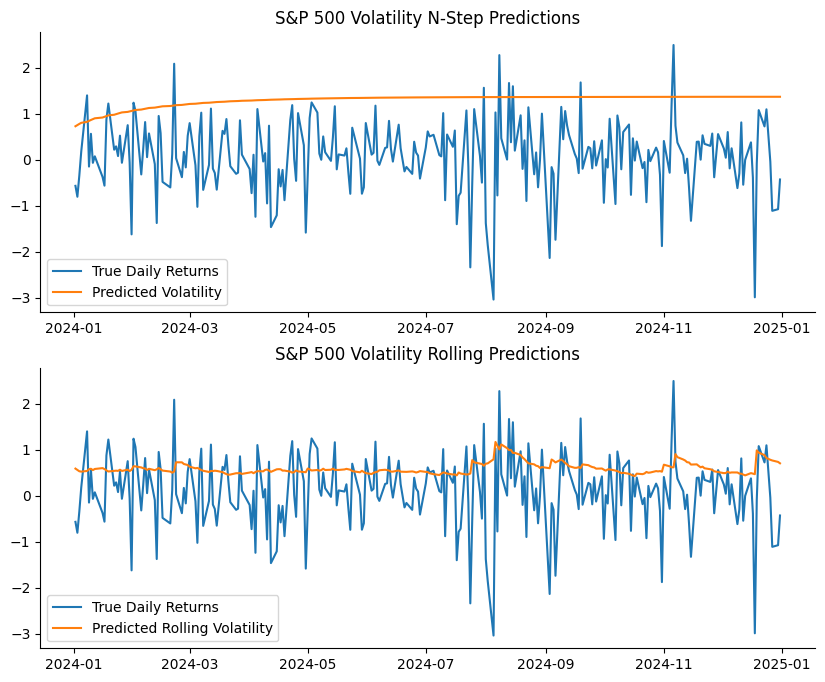

In [4]:
df = pd.read_csv(homepath + 'data/indices.csv', parse_dates=["Date"], index_col='Date')[['sp500']].rename(columns={'sp500':'Close'})

# Convert prices to log returns 
df['Return'] = np.pad(np.diff(np.log(df['Close'])) * 100, (1, 0), 'constant', constant_values=np.nan)
diff_ts = df['Return'].iloc[1:]
abs_returns = diff_ts.abs()

# Fit GARCH (1,1)
y_train, y_test = train_test_split(abs_returns, train_size= 0.8)
garch_mod = arch_model(y_train, mean = "Zero",  vol='Garch', p=1, q=1, rescale=False)
res_garch = garch_mod.fit()
# Forecast the test set 
yhat = res_garch.forecast(horizon = y_test.shape[0], reindex=True)


rolling_preds = []

for i in range(y_test.shape[0]):
    train = abs_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, p=1, q=1, rescale = False)
    model_fit = model.fit(disp='off')
    # One step ahead predictor
    pred = model_fit.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_preds = pd.Series(rolling_preds, index=y_test.index)


# Plot of predicted test data rolling volatility predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Customize first subplot: N-Step Ahead Predictions
ax1.spines[['top','right']].set_visible(False)
ax1.plot(diff_ts[-y_test.shape[0]:])
ax1.plot(y_test.index, np.sqrt(yhat.variance.values[-1,:]))
ax1.set_title("S&P 500 Volatility N-Step Predictions")
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

# Customize second subplot: Rolling Predictions
ax2.spines[['top','right']].set_visible(False)
ax2.plot(diff_ts[-y_test.shape[0]:])
ax2.plot(y_test.index, rolling_preds)
ax2.set_title("S&P 500 Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])

# Show final plots
plt.show()


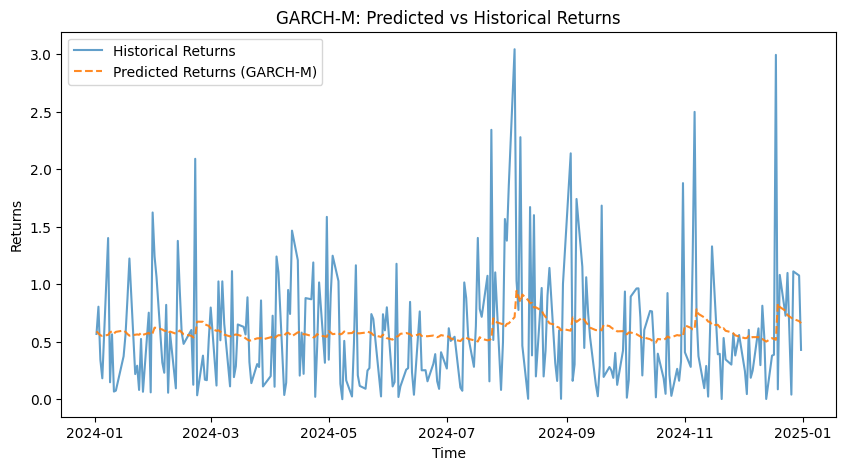

In [5]:
# Assume you already have historical returns and f_vol series
returns = y_test  # Your historical return series (Pandas Series)
f_vol = rolling_preds    # Your precomputed rolling GARCH volatility (Pandas Series)

# Ensure data alignment
data = pd.DataFrame({'returns': returns, 'f_vol': f_vol}).dropna()

# 1. Linear regression of returns on f_vol
X = sm.add_constant(data['f_vol'])  # Add constant for intercept
y = data['returns']

ols_model = sm.OLS(y, X).fit()
data['residuals'] = ols_model.resid  # Store residuals

# 2. Fit GARCH(1,1) on the residuals
garch = ZeroMean(data['residuals'])  # No mean term since we handled it via OLS
garch.volatility = GARCH(p=1, q=1)   # Standard GARCH(1,1)
res = garch.fit(disp="off")

# 3. Predict returns
predicted_vol = res.conditional_volatility
predicted_returns = ols_model.predict(X)  # Reuse OLS regression for return forecast

# 4. Plot historical vs predicted returns
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['returns'], label="Historical Returns", alpha=0.7)
plt.plot(data.index, predicted_returns, label="Predicted Returns (GARCH-M)", linestyle="dashed", alpha=0.9)
plt.legend()
plt.title("GARCH-M: Predicted vs Historical Returns")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.show()


## NAR 

In [28]:
data = pd.concat([y_test, rolling_preds], axis=1)
data.rename(columns={0:'rolling_preds'}, inplace=True)

data

,Return,rolling_preds
Date,,
2024-01-02,0.567666,0.591341
2024-01-03,0.804862,0.561237
2024-01-04,0.343427,0.533271
2024-01-05,0.182402,0.525997
2024-01-08,1.401595,0.539609
...,...,...
2024-12-24,1.098223,0.822406
2024-12-26,0.040574,0.783378
2024-12-27,1.111730,0.768257


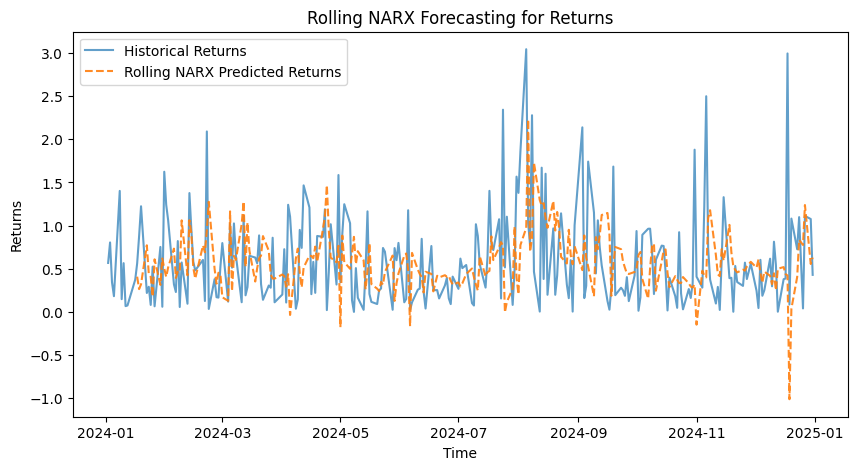

In [29]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# Sample Data (Replace with real returns and forecasted volatility)
returns = np.random.randn(1000)  # Simulated returns
f_vol = np.abs(np.random.randn(1000))  # Simulated forecasted volatility

# Convert to DataFrame
data = pd.concat([y_test, rolling_preds], axis=1)
data.rename(columns={0:'rolling_preds'}, inplace=True)

# Parameters
window_size = 10  # Rolling window length
predicted_returns = []

# Standardize data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Rolling Forecasting
for i in range(len(data) - window_size):
    train_X = data_scaled[i:i + window_size - 1, :]  # Features: returns, f_vol
    train_y = data_scaled[i + 1:i + window_size, 0]  # Target: Next return

    test_X = data_scaled[i + window_size - 1, :].reshape(1, -1)  # Latest data for prediction

    # Train NARX Model (MLPRegressor as a substitute for a deep learning NARX model)
    model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
    model.fit(train_X, train_y)

    # Predict next return
    predicted_returns.append(model.predict(test_X)[0])

# Convert predictions back to original scale
predicted_returns = scaler.inverse_transform(np.column_stack((predicted_returns, np.zeros(len(predicted_returns)))))[:, 0]

# Store results in DataFrame
data['predicted_returns'] = np.nan
data.iloc[window_size:, 2] = predicted_returns  # Align with time index

# Plot Results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(data.index, data['Return'], label="Historical Returns", alpha=0.7)
plt.plot(data.index, data['predicted_returns'], label="Rolling NARX Predicted Returns", linestyle="dashed", alpha=0.9)
plt.legend()
plt.title("Rolling NARX Forecasting for Returns")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.show()
